In [1]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic, accuracy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the data
movies_metadata = pd.read_csv('movies_metadata.csv')
keywords = pd.read_csv('keywords.csv')
credits = pd.read_csv('credits.csv')
ratings = pd.read_csv('ratings_small.csv')

C:\Users\SsDsS\AppData\Local\Temp\ipykernel_62952\1989873985.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('movies_metadata.csv')


In [3]:
# Convert 'id' column to string data type before merging
movies_metadata['id'] = movies_metadata['id'].astype(str)
keywords['id'] = keywords['id'].astype(str)
credits['id'] = credits['id'].astype(str)

# Merge movies_metadata, keywords, and credits data
movies_data = pd.merge(movies_metadata, keywords, on='id', how='left')
movies_data = pd.merge(movies_data, credits, on='id', how='left')

# Create the Surprise Dataset
reader = Reader(rating_scale=(0.5, 5), line_format='user item rating timestamp', sep=',')
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [4]:
# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use the User-Based Collaborative Filtering algorithm
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Set default prediction to 3
model = KNNBasic(sim_options=sim_options, bsl_options={'method': 'sgd', 'learning_rate': .005, 'n_epochs': 50}, verbose=0)
model.fit(trainset)

In [5]:
# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.9925
RMSE: 0.9925


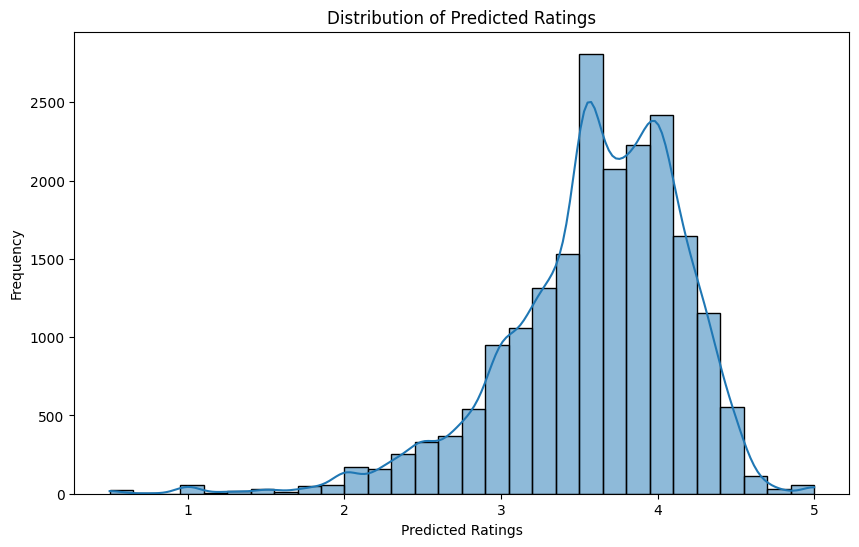

In [6]:
# Visualize the distribution of predicted ratings
predicted_ratings = [pred.est for pred in predictions]

plt.figure(figsize=(10, 6))
sns.histplot(predicted_ratings, bins=30, kde=True)
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Now, you can make recommendations for a specific user
user_id = 1
user_movies = ratings[ratings['userId'] == user_id]['movieId'].tolist()

# Get the list of movies the user hasn't rated
unrated_movies = ratings[~ratings['movieId'].isin(user_movies)]['movieId'].unique()

# Make predictions for the unrated movies
predictions_for_user = [(model.predict(user_id, movie_id), movie_id) for movie_id in unrated_movies]

# Get the top N recommendations
top_n = 10
recommendations = sorted(predictions_for_user, key=lambda x: x[0].est, reverse=True)[:top_n]

In [8]:
# Print the top recommendations with additional movie information
print("\nTop Recommendations:")
for prediction, movie_id in recommendations:
    # Check if the movie ID exists in movies_data after converting to string
    movie_id = str(movie_id)
    if movie_id in movies_data['id'].values:
        movie_info = movies_data[movies_data['id'] == movie_id].iloc[0]
        print(f"Movie ID: {movie_id}")
        print(f"Title: {movie_info['title']}")
        print(f"Genres: {movie_info['genres']}")
        print(f"Release Date: {movie_info['release_date']}")
        print(f"Overview: {movie_info['overview']}")
        print(f"Popularity: {movie_info['popularity']}")
        print(f"Estimated Rating: {prediction.est}\n")
    else:
        print(f"Movie ID {movie_id} not found in movies_data.\n")



Top Recommendations:
Movie ID: 2086
Title: Nick of Time
Genres: [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]
Release Date: 1995-11-22
Overview: Gene Watson is a public accountant who arrives on a train at Union Station in Los Angeles, accompanied by his 6-year-old daughter Lynn. Because of his ordinary looks, he is approached by a pair of sinister people named Smith and Jones.
Popularity: 6.848591
Estimated Rating: 5

Movie ID 1860 not found in movies_data.

Movie ID 5017 not found in movies_data.

Movie ID: 5062
Title: The Inquisitor
Genres: [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name': 'Drama'}, {'id': 9648, 'name': 'Mystery'}, {'id': 53, 'name': 'Thriller'}]
Release Date: 1981-09-21
Overview: A police inspector, suspecting an attorney of two child sex murders, has him held for a questioning session that goes on for hours.
Popularity: 2.445608
Estimated Rating: 5

Movie ID 51471 not found in movies_data.

Movie ID 7136 not found in mo